***CONSUMER START***

In [1]:
from kafka import KafkaConsumer
import pickle
import json
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt

***PREPARING KAFKA FOR DATA INCOMING***

In [2]:
bootstrap_servers = ['localhost:9092']
consumer = KafkaConsumer('temp_05', bootstrap_servers=bootstrap_servers, auto_offset_reset='earliest', group_id='my-group')

In [3]:
def removeID(msg):
    msg_i=msg.value.decode('utf-8')
    data_dict = json.loads(msg_i)
    ID=data_dict['ID']
    del data_dict['ID']
    data_list=[value for value in data_dict.values()]

    return data_list, ID

***PREDICTING***

In [4]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

with open("explainer.pkl", "rb") as f:
    explainer = pickle.load(f)

def predict(data_list):
    
    y_pred_test=model.predict([data_list])
    return y_pred_test

***EXPLAINATION***

In [5]:
def prepare(data_list):
    prev_data_frame = pd.DataFrame(data_list)
    data_frame=prev_data_frame.transpose().values[0]

    feature_names=[]
    for i in prev_data_frame.transpose():
        feature_names.append(i)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data_frame, check_additivity=False)
    shap_values = shap_values.transpose()
    
    return {'data_frame': data_frame, 'shap_values': shap_values, 'feature_names': feature_names}

In [6]:
# feature importance table

def plot_feature_importance(importance_df):
  plt.bar(importance_df['feature'], importance_df['importance'])
  plt.xlabel("Feature")
  plt.ylabel("Contribution")
  plt.title("Contribution of Each Feature in the Fraudulence")
  plt.xticks(rotation=45, ha='right')
  plt.grid(axis='y', linestyle='--', alpha=0.6)
  plt.tight_layout()
  plt.show()

def get_feature_importance_ranking(data_list):
  
  shap_values = prepare(data_list)['shap_values']
  feature_names = prepare(data_list)['feature_names']
  data_frame = prepare(data_list)['data_frame']
  # print(shap_values)

  for name, contribution in zip(feature_names, shap_values[1]):
    if(contribution > 0.065):
      print(f" - Feature: {name} (value: {data_frame[feature_names.index(name)]:.4f}) made the transaction Fraudulent by a Factor of:  {abs(contribution):.2f}.")
  
  feature_importances = np.abs(shap_values).mean(axis=0)
  importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
  importance_df.sort_values(by='importance', ascending=False, inplace=True)

  plot_feature_importance(importance_df)

In [7]:
# SHAP values individually

def plot_shap_value_distribution(data_list):
    
  shap_values = prepare(data_list)['shap_values']
  feature_names = prepare(data_list)['feature_names']
    
  for i in range(shap_values.shape[1]):
    plt.hist(shap_values[:, i])
    plt.xlabel("SHAP Value")
    plt.ylabel("Count")
    plt.title(f"Distribution of SHAP Values for {feature_names[i]}")
    plt.show()
    plt.clf()

In [8]:
# feature value - SHAP value pair individually

def explain_individual_datapoint(data_list):
    
  shap_values = prepare(data_list)['shap_values']
  feature_names = prepare(data_list)['feature_names']
  
  for feature_name, shap_value in zip(feature_names, shap_values[0]):
    print(f"Feature: {feature_name}, SHAP Value: {shap_value}")

In [9]:
def explain(data_list):
    
    get_feature_importance_ranking(data_list)
    # plot_shap_value_distribution(data_list)
    # explain_individual_datapoint(data_list)

***DATA INCOMING***

The transaction with ID: c6121043-d849-4a01-bfc2-d57775cfb9ab is Fraudulent
 - Feature: 10 (value: -4.0291) made the transaction Fraudulent by a Factor of:  0.17.
 - Feature: 14 (value: -5.7572) made the transaction Fraudulent by a Factor of:  0.22.


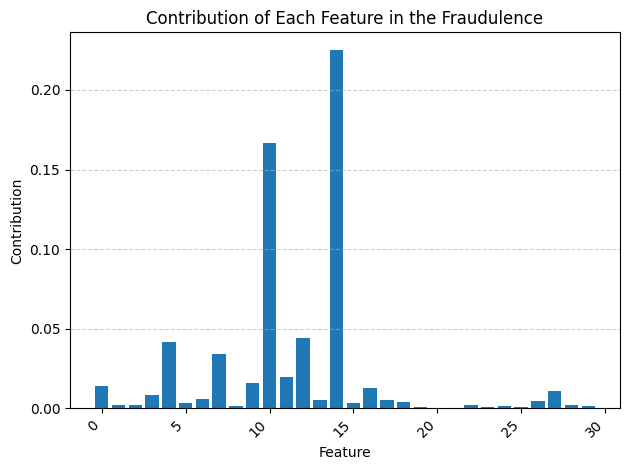

The transaction with ID: 8b6f6f18-7837-48b6-9995-511e3841168a is Fraudulent
 - Feature: 10 (value: -4.7076) made the transaction Fraudulent by a Factor of:  0.09.
 - Feature: 11 (value: 4.9058) made the transaction Fraudulent by a Factor of:  0.10.
 - Feature: 12 (value: -5.2084) made the transaction Fraudulent by a Factor of:  0.23.
 - Feature: 14 (value: -10.5440) made the transaction Fraudulent by a Factor of:  0.18.
 - Feature: 17 (value: -5.1331) made the transaction Fraudulent by a Factor of:  0.16.


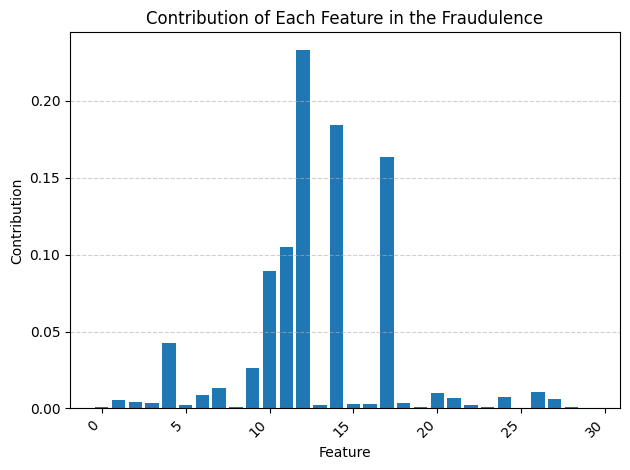

The transaction with ID: 169568fd-99e2-42f8-ac25-057bd53dc7ec is Fraudulent
 - Feature: 10 (value: -5.5764) made the transaction Fraudulent by a Factor of:  0.10.
 - Feature: 11 (value: 5.7837) made the transaction Fraudulent by a Factor of:  0.15.
 - Feature: 12 (value: -6.1177) made the transaction Fraudulent by a Factor of:  0.28.
 - Feature: 14 (value: -12.4515) made the transaction Fraudulent by a Factor of:  0.21.


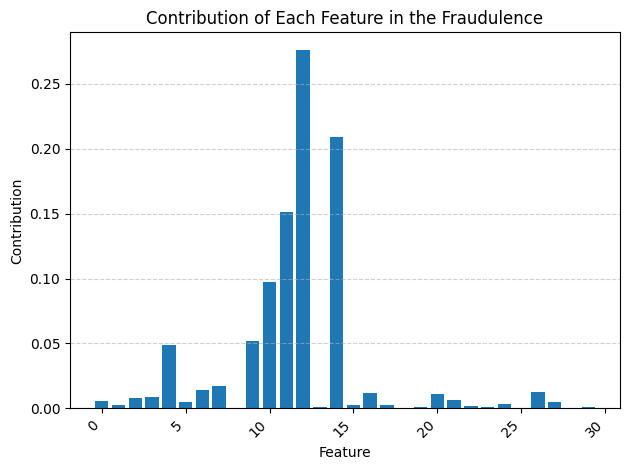

The transaction with ID: 8f39214f-0245-4759-af44-15a5c6a4848c is Fraudulent
 - Feature: 10 (value: -5.2581) made the transaction Fraudulent by a Factor of:  0.10.
 - Feature: 11 (value: 5.7163) made the transaction Fraudulent by a Factor of:  0.15.
 - Feature: 12 (value: -5.8104) made the transaction Fraudulent by a Factor of:  0.28.
 - Feature: 14 (value: -12.2891) made the transaction Fraudulent by a Factor of:  0.21.


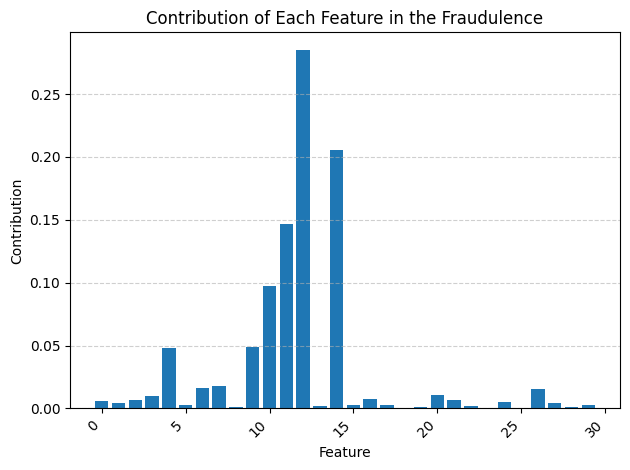

In [10]:
for msg in consumer:
    rL=removeID(msg)
    
    data_list=rL[0]
    ID=rL[1]

    y=predict(data_list)

    if(y==1):
        print(f"The transaction with ID: {ID} is Fraudulent")
        try:
            explain(data_list)
        except Exception as e:
            print('Something happened ', e)

***CONSUMER STOP***

In [ ]:
consumer.close()
print("Consumer stopped")